# Carregar Dados

In [7]:

import os
import numpy as np
import pandas as pd
import os
import re
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)


DATASET_DIR_NAME = "dataset"
CANDIDATE_DIRS = [
    os.path.join(".", DATASET_DIR_NAME),
    os.path.join(".", "dataset_extracted"),
    os.path.join(".", "data"),
    os.path.join(".", "f1"),
]

def find_dataset_dir(candidates):
    required = {"results.csv"}
    for d in candidates:
        if os.path.isdir(d):
            files = set(os.listdir(d))
            if required.issubset(files):
                return d
    raise FileNotFoundError("Pasta do dataset não encontrada.")

DATASET_DIR = find_dataset_dir(CANDIDATE_DIRS)

results = pd.read_csv(os.path.join(DATASET_DIR, "results.csv"))
status = pd.read_csv(os.path.join(DATASET_DIR, "status.csv")) if os.path.exists(os.path.join(DATASET_DIR, "status.csv")) else None
drivers = pd.read_csv(os.path.join(DATASET_DIR, "drivers.csv")) if os.path.exists(os.path.join(DATASET_DIR, "drivers.csv")) else None
races = pd.read_csv(os.path.join(DATASET_DIR, "races.csv")) if os.path.exists(os.path.join(DATASET_DIR, "races.csv")) else None
qualifying = pd.read_csv(os.path.join(DATASET_DIR, "qualifying.csv")) if os.path.exists(os.path.join(DATASET_DIR, "qualifying.csv")) else None
pit_stops = pd.read_csv(os.path.join(DATASET_DIR, "pit_stops.csv")) if os.path.exists(os.path.join(DATASET_DIR, "pit_stops.csv")) else None

print("results:", results.shape)


2.20.0
results: (26759, 18)


In [12]:
DATASET_DIR_NAME = "dataset" 
CANDIDATE_DIRS = [
    os.path.join(".", DATASET_DIR_NAME),
    os.path.join(".", "dataset_extracted"), 
    os.path.join(".", "data"),
    os.path.join(".", "f1"),
]

def find_dataset_dir(candidates):
    required = {"results.csv", "status.csv"}
    for d in candidates:
        if os.path.isdir(d):
            files = set(os.listdir(d))
            if required.issubset(files):
                return d
    raise FileNotFoundError(
        "Erro Pasta"
    )

DATASET_DIR = find_dataset_dir(CANDIDATE_DIRS)
print("Local do dataset:", DATASET_DIR)

def read_csv_safe(name):
    path = os.path.join(DATASET_DIR, name)
    if not os.path.exists(path):
        print("erro")
        return None
    return pd.read_csv(path)

results = read_csv_safe("results.csv")
status = read_csv_safe("status.csv")
drivers = read_csv_safe("drivers.csv")
races = read_csv_safe("races.csv")
qualifying = read_csv_safe("qualifying.csv")
pit_stops = read_csv_safe("pit_stops.csv")

print("Tabelas carregadas:")
for nm,df in [('results', results), ('status', status), ('drivers', drivers), ('races', races), ('qualifying', qualifying), ('pit_stops', pit_stops)]:
    if df is not None:
        print(f" - {nm}: {df.shape}")

Local do dataset: .\dataset
Tabelas carregadas:
 - results: (26759, 18)
 - status: (139, 2)
 - drivers: (861, 9)
 - races: (1125, 18)
 - qualifying: (10494, 9)
 - pit_stops: (11371, 7)


# Label 

In [8]:

res = results.copy()
res['position_str'] = res['position'].astype(str)
res['position_num'] = pd.to_numeric(res['position_str'], errors='coerce')
res['top10'] = ((res['position_num'] >= 1) & (res['position_num'] <= 10)).astype(int)
y = res['top10'].astype(int)
print(y.value_counts())


top10
0    15777
1    10982
Name: count, dtype: int64


# Features

In [9]:

df = res.copy()

if drivers is not None and races is not None:
    drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')
    if 'date' in races.columns:
        races['date'] = pd.to_datetime(races['date'], errors='coerce')
    df = df.merge(races[['raceId','year','date']], on='raceId', how='left')
    df = df.merge(drivers[['driverId','dob']], on='driverId', how='left')
    df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25
else:
    if races is not None and 'year' not in df.columns:
        df = df.merge(races[['raceId','year']], on='raceId', how='left')
    df['driver_age'] = np.nan

if qualifying is not None:
    q = qualifying.groupby(['raceId','driverId'], as_index=False)['position'].min().rename(columns={'position':'best_quali_pos'})
    df = df.merge(q, on=['raceId','driverId'], how='left')
else:
    df['best_quali_pos'] = np.nan

if pit_stops is not None:
    p = pit_stops.groupby(['raceId','driverId'], as_index=False)['stop'].count().rename(columns={'stop':'pit_stop_count'})
    df = df.merge(p, on=['raceId','driverId'], how='left')
else:
    df['pit_stop_count'] = np.nan

feature_cols_numeric = ['grid','year','driver_age','best_quali_pos','pit_stop_count']
for c in feature_cols_numeric:
    if c not in df.columns:
        df[c] = np.nan
    df[c] = pd.to_numeric(df[c], errors='coerce')

TOP_N_CONSTRUCTORS = 15
if 'constructorId' in df.columns:
    top_cons = df['constructorId'].value_counts().head(TOP_N_CONSTRUCTORS).index
    df['constructor_cat'] = df['constructorId'].where(df['constructorId'].isin(top_cons), other=-1).astype(int)
    dummies = pd.get_dummies(df['constructor_cat'], prefix='constructor', drop_first=False)
else:
    dummies = pd.DataFrame(index=df.index)

X = pd.concat([df[feature_cols_numeric], dummies], axis=1)
valid = y.notna() & X.notna().any(axis=1)
X = X.loc[valid].copy()
y = y.loc[valid].copy()

for c in feature_cols_numeric:
    if c in X.columns:
        X[c] = X[c].fillna(X[c].median())

print(X.shape, y.shape)


(26759, 21) (26759,)


# Divisão e Escalonamento

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
print(X_train.shape, X_test.shape)


(21407, 21) (5352, 21)


# Modelo

Epoch 1/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - accuracy: 0.6063 - loss: 0.7347 - val_accuracy: 0.6876 - val_loss: 0.5969
Epoch 2/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.6924 - loss: 0.5903 - val_accuracy: 0.6878 - val_loss: 0.5950
Epoch 3/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - accuracy: 0.6883 - loss: 0.5957 - val_accuracy: 0.6878 - val_loss: 0.5950
Epoch 4/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.6862 - loss: 0.5944 - val_accuracy: 0.6872 - val_loss: 0.5946
Epoch 5/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.6923 - loss: 0.5907 - val_accuracy: 0.6857 - val_loss: 0.5949
Epoch 6/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step - accuracy: 0.6931 - loss: 0.5879 - val_accuracy: 0.6893 - val_loss: 0.5950
Epoch 7/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.6926 - loss: 0.5895 - val_accuracy: 0.6882 - val_loss: 0.5949
Epoch 8/50
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - accuracy: 0.6924 -

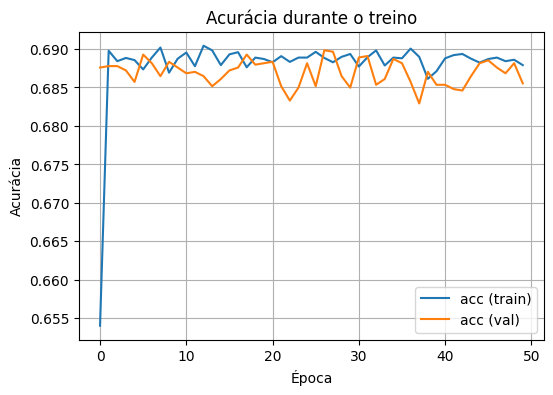

In [11]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()
model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_s.shape[1],))])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_s, y_train, validation_data=(X_test_s, y_test), epochs=50, batch_size=10, verbose=1)

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='acc (train)')
plt.plot(history.history['val_accuracy'], label='acc (val)')
plt.title('Acurácia durante o treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


# Avaliação

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
accuracy: 0.6870
f1: 0.5320
              precision    recall  f1-score   support

           0     0.6866    0.8634    0.7649      3156
           1     0.6884    0.4335    0.5320      2196

    accuracy                         0.6870      5352
   macro avg     0.6875    0.6485    0.6485      5352
weighted avg     0.6873    0.6870    0.6693      5352



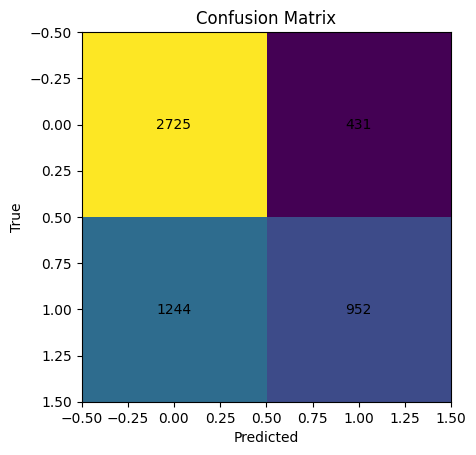

In [6]:

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_prob = model.predict(X_test_s)
y_pred = (y_prob >= 0.5).astype(int).ravel()

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy: {acc:.4f}")
print(f"f1: {f1:.4f}")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.show()
